In [5]:
from tensorflow import random as tf_random
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import os
from os.path import isfile, join
import pandas as pd
from math import ceil
%matplotlib inline

In [6]:
master_image_size = 256, 256
master_color_channels = 1
base_image_dir = 'grayscale-256x256'

In [7]:
def get_new_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(master_image_size[0], master_image_size[1], master_color_channels)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=0.5e-4), metrics=['acc'])
    return model

In [8]:
def train_validation_test(base_path, train_fraction=0.8, shuffle_seed=0):
    """
    Reads images in a directory and splits them up according to class
    
    Assumes a binary classification, with EQUAL COUNTS in each
    class.
    
    It re-seeds at each time so that the shuffle will always come up
    with the same splits.
    """
    random.seed(shuffle_seed)
    
    all_images_list = []
    
    for filename in os.listdir(base_path):
        if isfile(join(base_path, filename)):
            image_class = filename.split('.')[0]
            all_images_list.append({'class': image_class, 'filename': filename})
    
    all_images = pd.DataFrame(all_images_list)
    all_images = all_images.sample(frac=1).reset_index(drop=True)
    all_classes = all_images['class'].unique()
    
    first_class_name = all_classes[0]
    second_class_name = all_classes[1]
    
    first_class = all_images.copy().where(all_images['class'] == first_class_name).dropna()
    second_class = all_images.copy().where(all_images['class'] == second_class_name).dropna()

    train_row_count = int(len(first_class) * train_fraction)
    test_val_count = len(first_class) - train_row_count
    
    first_class_train = first_class.iloc[2 * test_val_count:]
    first_class_val = first_class.iloc[test_val_count:2 * test_val_count]
    first_class_test = first_class.iloc[0:test_val_count]
    
    second_class_train = second_class.iloc[2 * test_val_count:]
    second_class_val = second_class.iloc[test_val_count:2 * test_val_count]
    second_class_test = second_class.iloc[0:test_val_count]
    
    train = first_class_train.append(second_class_train).reset_index().drop('index', axis=1)
    val = first_class_val.append(second_class_val).reset_index().drop('index', axis=1)
    test = first_class_test.append(second_class_test).reset_index().drop('index', axis=1)
    
    return train, val, test

In [9]:
def train_validation_test_generators(src_dir, train_fraction=0.8, shuffle_seed=0):
    train, validation, test = train_validation_test(src_dir, train_fraction, shuffle_seed)

    train_datagen = image.ImageDataGenerator(rescale=1.0/255)
    test_datagen = image.ImageDataGenerator(rescale=1.0/255)
    validation_datagen = image.ImageDataGenerator(rescale=1.0/255)

    train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                        directory=src_dir,
                                                        target_size=master_image_size,
                                                        batch_size=20,
                                                        shuffle=False,
                                                        color_mode='grayscale',
                                                        class_mode='binary')

    validation_generator = train_datagen.flow_from_dataframe(dataframe=validation,
                                                      directory=src_dir,
                                                      target_size=master_image_size,
                                                      batch_size=20,
                                                      shuffle=False,
                                                      color_mode='grayscale',
                                                      class_mode='binary')

    test_generator = train_datagen.flow_from_dataframe(dataframe=test,
                                                       directory=src_dir,
                                                       target_size=master_image_size,
                                                       batch_size=20,
                                                       shuffle=False,
                                                       color_mode='grayscale',
                                                       class_mode='binary')
    
    return train_generator, validation_generator, test_generator, train, validation, test

In [10]:
train_generator, validation_generator, test_generator, train_df, validation_df, test_df = train_validation_test_generators(base_image_dir)

model = get_new_model()

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=50)

Found 246 validated image filenames belonging to 2 classes.
Found 82 validated image filenames belonging to 2 classes.
Found 82 validated image filenames belonging to 2 classes.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
100/100 [==============================] - 13s 130ms/step - loss: 0.7055 - acc: 0.4979 - val_loss: 0.6962 - val_acc: 0.6829
Epoch 2/10
100/100 [==============================] - 11s 107ms/step - loss: 0.6835 - acc: 0.5524 - val_loss: 0.4853 - val_acc: 0.5122
Epoch 3/10
100/100 [==============================] - 11s 107ms/step - loss: 0.6067 - acc: 0.6651 - val_loss: 0.5205 - val_acc: 0.6951
Epoch 4/10
100/100 [==============================] - 11s 106ms/step - loss: 0.4992 - acc: 0.7468 - val_loss: 0.5758 - val_acc: 0.6829
Epoch 5/10
100/100 [==============================] - 11s 107ms/step - loss: 0.4352 - acc: 0.7960 - val_loss: 1.5806 - val_acc: 0.7683
Epoch 6/10
100/100 [=======

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)      

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

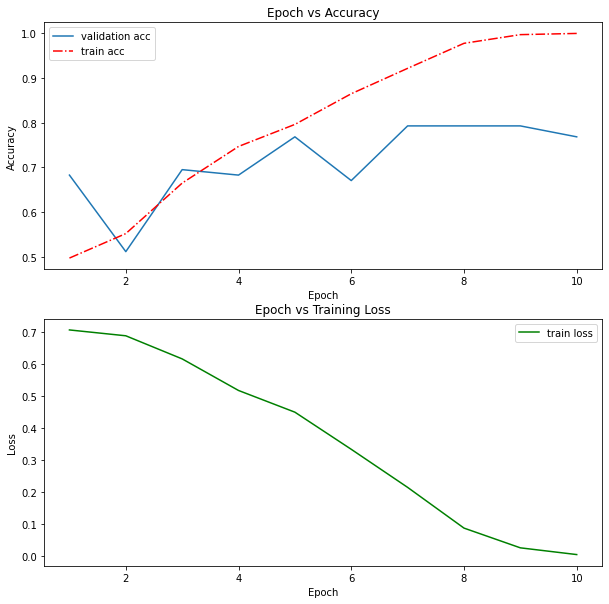

In [13]:
epochs = range(1, len(acc) + 1)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Epoch vs Accuracy')
axs[0].plot(epochs, val_acc, label='validation acc')
axs[0].plot(epochs, acc, 'r', ls='-.', label='train acc')
axs[0].legend()

axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Epoch vs Training Loss')
axs[1].plot(epochs, loss, 'g', label='train loss')
axs[1].legend()

In [14]:
model = get_new_model()

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=5,
                              validation_data=validation_generator,
                              validation_steps=50)

Epoch 1/5
100/100 [==============================] - 11s 108ms/step - loss: 0.6994 - acc: 0.4423 - val_loss: 0.6748 - val_acc: 0.5000
Epoch 2/5
100/100 [==============================] - 11s 106ms/step - loss: 0.7036 - acc: 0.5376 - val_loss: 0.7130 - val_acc: 0.7439
Epoch 3/5
100/100 [==============================] - 11s 106ms/step - loss: 0.6139 - acc: 0.6672 - val_loss: 0.8552 - val_acc: 0.7439
Epoch 4/5
100/100 [==============================] - 11s 105ms/step - loss: 0.5163 - acc: 0.7256 - val_loss: 1.2313 - val_acc: 0.7561
Epoch 5/5
100/100 [==============================] - 11s 107ms/step - loss: 0.4304 - acc: 0.7955 - val_loss: 1.6544 - val_acc: 0.7683


In [15]:
def name_of_class_from_prediction_value(value):
    if value < 0.5:
        return 'YES'
    else:
        return 'NO'

In [16]:
def read_images_from_df_and_classify(test_df, dirname, image_size, classifier):
    singles = []
    for filename in test_df['filename']:
        single = image.load_img(os.path.join(dirname, filename), target_size=image_size, color_mode='grayscale')
        single = image.img_to_array(single)
        single /= 255.0
        singles.append(single)
    batch = np.stack(singles, axis=0)
    predicted_classes = classifier.predict(batch)
    return singles, predicted_classes.flatten()

In [17]:
def classify_images_from_df_and_display(test_df, dirname, image_size, classifer):
    images, predicted_classes = read_images_from_df_and_classify(test_df, dirname, image_size, classifer)
    ncols = 4
    nrows = int(ceil(len(images) / ncols))
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 40))
    for image, predicted_class, ax in zip(images, predicted_classes, axs.reshape(-1)):
        title = name_of_class_from_prediction_value(predicted_class)
        ax.imshow(image.reshape(image_size), cmap='gray')
        ax.set_title(title)
        
    plt.savefig("first_attempt_test_classifications.png")

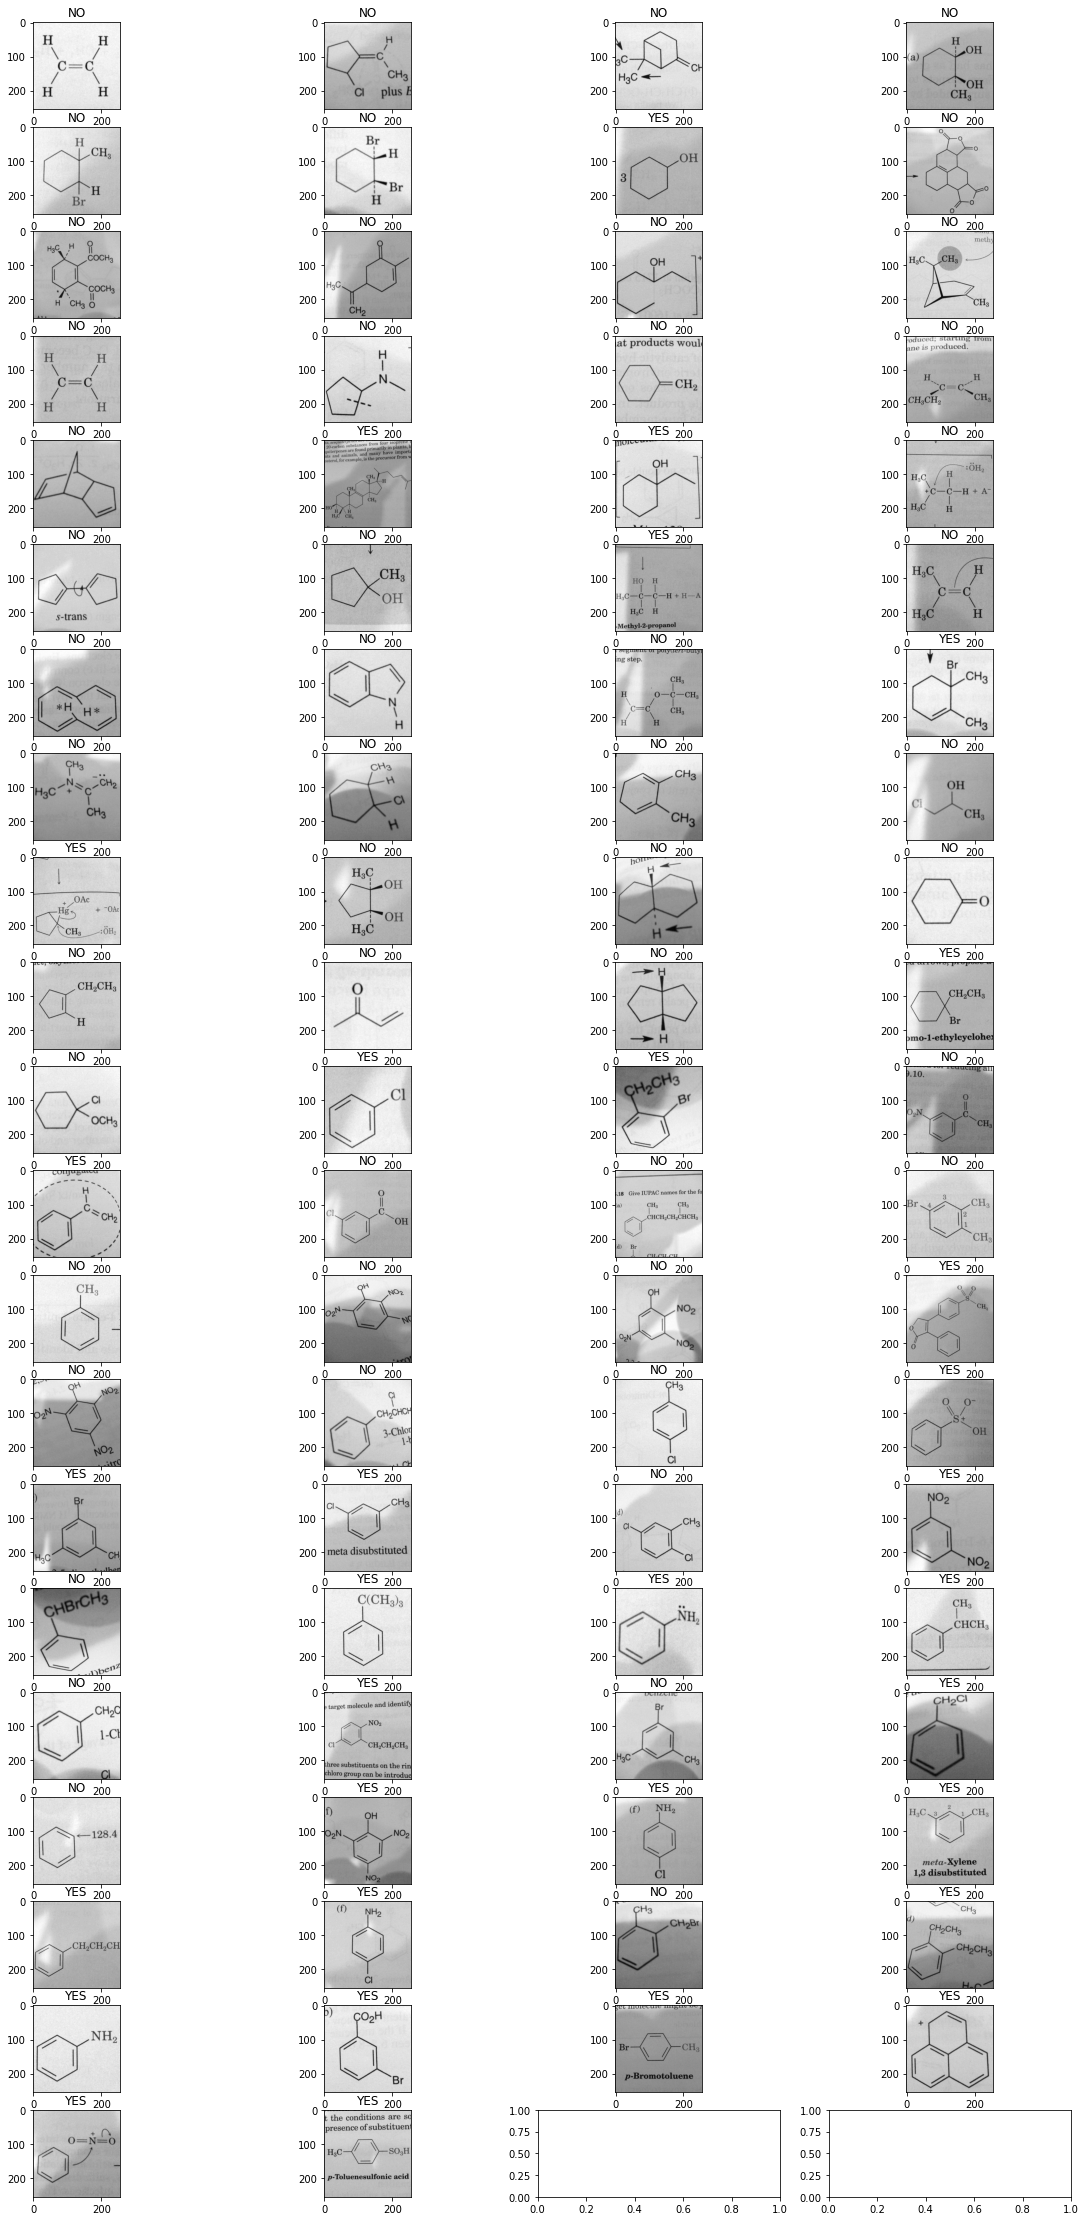

In [18]:
classify_images_from_df_and_display(test_df, base_image_dir, master_image_size, model)